# Derivatives Analytics - Inheritance and Polymorphism

**Author**: [Gabriele Pompa](https://www.linkedin.com/in/gabrielepompa/): gabriele.pompa@unisi.com

# Table of contents

[Executive Summary](#executive-summary)

1. [Cash-Or-nothing Digital Options](#digitals)
2. [Polymorphism in functions and class methods](#poly)
3. [Inheritance](#inheritance)\
    3.1. [Abstract classes and interfaces](#abstract)\
    3.2. [Inheritance and Polymorphism](#inheritance-and-poly)

### **Resources**: 

- [_Python for Finance (2nd ed.)_](http://shop.oreilly.com/product/0636920117728.do): Chapter 6 Object-Oriented Programming.


- [Object-Oriented Programming in Python](https://python-textbok.readthedocs.io/en/1.0/index.html): Section [Object-oriented programming](https://python-textbok.readthedocs.io/en/1.0/Object_Oriented_Programming.html)


- [Polymorphism in Python](https://www.programiz.com/python-programming/polymorphism)

# Executive Summary <a name="executive-summary"></a>

In this notebook we introduce inheritance and polymorphism which are two milestones in object-oriented programming. We present these concepts introducing digital cash-or-nothing options and observing their similarities with plain-vanilla options. Inheritance and polymorphism allow us to leverage on the financial similarities between these two contracts and eventually represent them more efficiently as classes.

The following sections are organized as follows:

- In Sec. [1](#digitals) we introduce cash-or-nothing digital options, modeling them as a `DigitalOption` class.
- In Sec. [2](#poly) we introduce polymorphism in Python in functions and classes methods.
- In Sec. [3](#inheritance) we introduce inheritance and model plain-vanilla options and digitals as `PlainVaillaOption` and `DigitalOption` sub-classes of a common base class `EuropeanOption`, representing generically contracts with european-style exercise.

These are the basic imports

In [1]:
# for NumPy arrays
import numpy as np

# for Pandas Series and DataFrame
import pandas as pd

# for statistical functions
from scipy import stats

# for Matplotlib plotting
import matplotlib.pyplot as plt

# to do inline plots in the Notebook
%matplotlib inline

# for Operating System operations
import os

# for some mathematical functions
import math

# for date management
import datetime as dt

# 1. Cash-Or-nothing Digital Options <a name="digitals"></a>

A digital cash-or-nothing (CON) call/put option of maturity $T$ and strike $K$ on an asset $S$ is a contract paying to the owner a certain amount of cash $Q$ should the asset settle above/below the strike at maturity. The payoff of a digital call option contract at time $T$ is then

$$
Q  \times \mathcal{I}_{\left\{S_T > K\right\}}
$$

and, symmetrically, for a put option

$$
Q  \times \mathcal{I}_{\left\{S_T \leq K\right\}}
$$

where $\mathcal{I}_{x}$ is the indicator function for event $x$, worth $1$ in case $x$ materializes and $0$ otherwise.

As before, we consider non-dividend paying underlying asset $S$. At any time $t \leq T$, the price $c_t$ of the digital CON call option under the Black-Scholes model is given by

$$
c^{CON}_t = Q e^{-r \tau} N(d_2)
$$

where $\tau = T-t$ is the option time-to-maturity, $r$ is the continuously compounding short-rate, $N(z)$ is the cumulative distribution function of a standard normal random variable and the $d_2$ argument has been already defined for plain-vanilla options. For theoretical background (an notation) we refer to [_Financial Modeling 1_ lecture notes](https://finmod1.wordpress.com/lecture-notes/) from Professor Pacati.

Independently from the valuation model used to price the option (we assume constant deterministic short-rate $r$ here and everywhere in this notebook), there are non-arbitrage arguments leading to upper and lower limits for the price of the CON options. At any time $t \leq T$, the price $\text{price}_t$ of both call and put CONs satisfies:

$$
0 \leq \text{price}_t \leq Q e^{-r \tau}
$$

This can be easily understood: since both type of CON options, at most, pay an amount of cash $Q$ in $T$, at any time $t \leq T$ they cannot be worth more than the discounted (from $T$ to $t$) amount of cash, that is $Q e^{-r (T-t)} = Q e^{-r \tau}$. Moreover, since the worst that can happen owning a CON option is that it expires worthless in $T$ (that is, not paying any cash), its current market value cannot be negative, then $0$ has to be the lower bound. 

Moreover, from the financial point of view, CON call and put prices are related by the following _parity_ relation

$$
c^{CON}_t + p^{CON}_t = Qe^{-r\tau}
$$

which we can use to compute the put price $p^{CON}_t$, once we know the call's price $c^{CON}_t$ and the other contract variables.

In the spirit of the `PlainVaillaOption` class developed before, we implement a Black-Scholes pricer for digital options as a `DigitalOption` class

For convenience, we report here `PlainVanillaOption` class

In [2]:
class PlainVanillaOption:
    """
    PlainVanillaOption class implementing payoff and pricing of plain-vanilla call and put options.
    Put price is calculated using put-call parity
    
    Attributes:
    -----------
        type (str):               type of the options. Can be either 'call' or 'put';
        S_t (float):              spot price of the underlying asset at the valuation date 't';
        K (float):                strike price;
        t (str; dt.datetime):     valuation date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        T (str; dt.datetime):     expiration date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        tau (float):              time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                continuously compounded short-rate;
        sigma (float):            volatility of underlying asset;
    
    Public Methods:
    --------   
    
        getters and setters for all attributes
        
        payoff: float
            Computes the payoff of the option and returns it

        price_upper_limit: float 
            Returns the upper limit for a vanilla option price.

        price_lower_limit: float 
            Returns the lower limit for a vanilla option price.
            
        price: float
            Computes the exact price of the option and returns it, using call_price() or put_price()

    """
    
    def __init__(self, option_type, S_t, K, t, T, r, sigma):

        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
        
        self.__type  = option_type
        self.__S     = S_t
        self.__K     = K
        self.__t     = dt.datetime.strptime(t, "%d-%m-%Y") if isinstance(t, str) else t
        self.__T     = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        self.__tau   = self.__time_to_maturity()
        self.__r     = r
        self.__sigma = sigma
        
        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $S_t$",
                'payoff':            r"Payoff: $max(S-K, 0)$",
                'price_lower_limit': r"Lower limit: $max(S_t - K e^{-r \tau}, 0)$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $K e^{-r \tau}$",
                'payoff':            r"Payoff: $max(K-S, 0)$",
                'price_lower_limit': r"Lower limit: $max(K e^{-r \tau} - S_t, 0)$"}
        }
                
    def __repr__(self):
        return r"PlainVanillaOption('{}', S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_type(self):
        return self.__type
    
    def get_S(self):
        return self.__S
    
    def get_K(self):
        return self.__K
    
    def get_t(self):
        return self.__t

    def get_T(self):
        return self.__T

    def get_tau(self):
        return self.__tau
    
    def get_r(self):
        return self.__r

    def get_sigma(self):
        return self.__sigma
    
    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label]    
    
    # setters
    def set_type(self, option_type):
        self.__type = option_type
        
        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
        
    def set_S(self, S):
        self.__S = S
        
    def set_K(self, K):
        self.__K = K
    
    def set_t(self, t):
        self.__t = dt.datetime.strptime(t, "%d-%m-%Y") if isinstance(t, str) else t
        # update time to maturity, given changed t, to keep internal consistency
        self.__update_tau() 

    def set_T(self, T):
        self.__T = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        # update time to maturity, given changed T, to keep internal consistency
        self.__update_tau() 
    
    def set_tau(self, tau):
        self.__tau = tau
        # update expiration date, given changed tau, to keep internal consistency
        # we could have updated valuation date as well, but this is a stylistic choice
        self.__update_T()

    def set_r(self, r):
        self.__r = r

    def set_sigma(self, sigma):
        self.__sigma = sigma
        
    # update methods (private)
    def __update_tau(self):
        self.__tau = self.__time_to_maturity()

    def __update_T(self):
        self.__T = self.__t + dt.timedelta(days=math.ceil(self.__tau*365))

    # time to maturity calculation
    def __time_to_maturity(self):
        return (self.__T - self.__t).days / 365.0
    
    # payoff calculation
    def payoff(self):
        # call case
        if self.get_type() == 'call':
            return max(0.0, self.get_S() - self.get_K())
        # put case
        else:
            return max(0.0, self.get_K() - self.get_S())

    # upper price limit
    def price_upper_limit(self):
        # call case
        if self.get_type() == 'call':
            return self.get_S()
        # put case
        else:
            return self.get_K()*np.exp(-self.get_r() * self.get_tau())

    # lower price limit
    def price_lower_limit(self):
        # call case
        if self.get_type() == 'call':
            return max(self.get_S() - self.get_K()*np.exp(-self.get_r() * self.get_tau()), 0)
        # put case
        else:
            return max(self.get_K()*np.exp(-self.get_r() * self.get_tau()) - self.get_S(), 0)
            
    # price calculation
    def price(self):
        # call case
        if self.get_type() == 'call':
            return self.__call_price()
        # put case
        else:
            return self.__put_price()
          
    def __call_price(self):
        
        # some local variables retrieved to be used repeatedly
        S = self.get_S()
        tau = self.get_tau()
        
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.payoff()
        else:
            K     = self.get_K()
            r     = self.get_r()
            sigma = self.get_sigma()

            d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
            d2 = d1 - sigma * np.sqrt(tau)

            price = S * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self):
        """ Put price from Put-Call parity relation: Call + Ke^{-r*tau} = Put + S"""
        return self.__call_price() + self.get_K() * np.exp(- self.get_r() * self.get_tau()) - self.get_S()        

The similarity with plain-vanilla options is apparent. The only difference is:

- the additional parameter `self.__Q` needed to initialize the digital option class with the cash amount $Q$;

- the functional form of the payoff, price boundaries and price.

In [3]:
class DigitalOption(object):
    """
    DigitalOption class implementing payoff and pricing of digital call and put options.
    Put price is calculated using put-call parity
    
    Attributes:
    -----------
        type (str):               type of the options. Can be either 'call' or 'put';
        Q (float):                cash amount
        S_t (float):              spot price of the underlying asset at the valuation date 't';
        K (float):                strike price;
        t (str; dt.datetime):     valuation date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        T (str; dt.datetime):     expiration date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        tau (float):              time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                continuously compounded short-rate;
        sigma (float):            volatility of underlying asset;
    
    Public Methods:
    --------   
    
        getters and setters for all attributes
        
        payoff: float
            Computes the payoff of the option and returns it

        price_upper_limit: float 
            Returns the upper limit for a CON digital option price.

        price_lower_limit: float 
            Returns the lower limit for a CON digital option price
            .
        price: float
            Computes the exact price of the option and returns it, using call_price() or put_price()

    """
    
    def __init__(self, option_type, cash_amount, S_t, K, t, T, r, sigma):

        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
        
        self.__type  = option_type
        self.__Q     = cash_amount
        self.__S     = S_t
        self.__K     = K
        self.__t     = dt.datetime.strptime(t, "%d-%m-%Y") if isinstance(t, str) else t
        self.__T     = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        self.__tau   = self.__time_to_maturity()
        self.__r     = r
        self.__sigma = sigma
        
        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S > K)$",
                'price_lower_limit': r"Lower limit: $0$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S \leq K)$",
                'price_lower_limit': r"Lower limit: $0$"}
        }        
                
    def __repr__(self):
        return r"DigitalOption('{}', cash={:.1f}, S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_Q(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_type(self):
        return self.__type
    
    def get_Q(self):
        return self.__Q
    
    def get_S(self):
        return self.__S
    
    def get_K(self):
        return self.__K
    
    def get_t(self):
        return self.__t

    def get_T(self):
        return self.__T

    def get_tau(self):
        return self.__tau
    
    def get_r(self):
        return self.__r

    def get_sigma(self):
        return self.__sigma
    
    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label]    
    
    # setters
    def set_type(self, option_type):
        self.__type = option_type
        
        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
    
    def set_Q(self, cash_amount):
        self.__Q = cash_amount
        
    def set_S(self, S):
        self.__S = S
        
    def set_K(self, K):
        self.__K = K
    
    def set_t(self, t):
        self.__t = dt.datetime.strptime(t, "%d-%m-%Y") if isinstance(t, str) else t
        # update time to maturity, given changed t, to keep internal consistency
        self.__update_tau() 

    def set_T(self, T):
        self.__T = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        # update time to maturity, given changed T, to keep internal consistency
        self.__update_tau() 
    
    def set_tau(self, tau):
        self.__tau = tau
        # update expiration date, given changed tau, to keep internal consistency
        # we could have updated valuation date as well, but this is a stylistic choice
        self.__update_T()

    def set_r(self, r):
        self.__r = r

    def set_sigma(self, sigma):
        self.__sigma = sigma
        
    # update methods (private)
    def __update_tau(self):
        self.__tau = self.__time_to_maturity()

    def __update_T(self):
        self.__T = self.__t + dt.timedelta(days=math.ceil(self.__tau*365))

    # time to maturity method (private)
    def __time_to_maturity(self):
        return (self.__T - self.__t).days / 365.0
    
    # payoff calculation
    def payoff(self):
        # call case
        if self.get_type() == 'call':
            return self.get_Q() * int(self.get_S() > self.get_K())
        # put case
        else:
            return self.get_Q() * int(self.get_S() <= self.get_K())
        
    # upper price limit
    def price_upper_limit(self):
        # call case
        if self.get_type() == 'call':
            return self.get_Q()*np.exp(-self.get_r() * self.get_tau())
        # put case
        else:
            return self.get_Q()*np.exp(-self.get_r() * self.get_tau())

    # lower price limit
    def price_lower_limit(self):
        # call case
        if self.get_type() == 'call':
            return 0.0
        # put case
        else:
            return 0.0
        
    # price calculation
    def price(self):
        # call case
        if self.get_type() == 'call':
            return self.__call_price()
        # put case
        else:
            return self.__put_price()
          
    def __call_price(self):
        
        # some local variables retrieved to be used repeatedly
        S = self.get_S()
        tau = self.get_tau()
        
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.payoff()
        else:
            Q     = self.get_Q()
            K     = self.get_K()
            r     = self.get_r()
            sigma = self.get_sigma()

            d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
            d2 = d1 - sigma * np.sqrt(tau)

            price = Q * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self):
        """ Put price from Put-Call parity relation: CON_Call + CON_Put = Qe^{-r*tau}"""
        return self.get_Q() * np.exp(- self.get_r() * self.get_tau()) - self.__call_price()        

Here is a `DigitalOption` object representing a digital CON call option

In [4]:
CON_Call = DigitalOption(option_type='call', cash_amount = 1.0, S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2)
CON_Call

DigitalOption('call', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [5]:
type(CON_Call)

__main__.DigitalOption

In [6]:
isinstance(CON_Call, DigitalOption)

True

In [7]:
CON_Call.price()

0.29674605684957245

and here another one representing a CON put option

In [8]:
CON_Put = DigitalOption(option_type='put', cash_amount = 1.0, S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2)
CON_Put

DigitalOption('put', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [9]:
type(CON_Put)

__main__.DigitalOption

In [10]:
isinstance(CON_Put, DigitalOption)

True

In [11]:
CON_Put.price()

0.6687932243156424

In [12]:
CON_Put.payoff()

1.0

# 2. Polymorphism in functions and class methods <a name="poly"></a>

Polymorphism (from ancient Greek: $\pi \omicron \lambda \upsilon$ + $\mu \omicron \rho \phi \eta'$ = $multiple$ + $shape$) is the condition of occurrence of the same thing in different forms. For a good treatment of polymorhism in Python refer to [this blog post](https://www.programiz.com/python-programming/polymorphism).

When a function can works with different data-types, that is it can be called with input variables of different data-type, that function is implementing polymorphism. Think for example to function `len()`, defined in the Python standard library: `len()` can works:
- on Python Lists: `len(List)` returns the number of elements of the List;
- on Python Strings: `len(String)` returns the number of characters of the String;
- on Pthon Dicts: `len(Dict)` returns the number of keys of the Dictionary.

Thus `len()` can works on different data-types, with specific implementations for each data-type.

We can have polymorphism in class methods too. The fact that both `PlainVanillaOption` and `DigitalOption` classes define methods with the same name (like `.payoff()`, `.price()` as well as getters and setters for the attributes they have in common), is an example of _polymorphism._ Of course the implementations can be completely different, what matters is the fact that they share the same name. Indeed, as long as we are concerned with the output of the `.price()` (as well as other methods with same name in the two classes), we can call those method disregarding the object on which we are calling it (should it be a `PlainVanillaOption` and `DigitalOption` object). We say that `.price()` method (as well as other methods with same name in the two classes) is _polymorphic_ and the two classes are implementing polymorphism through it. 

Let's see this in practice. We can leverage the polymorphism of `PlainVanillaOption` and `DigitalOption` classes to use our plotting functions `plot_multi_tau(option,...)` and `plot_single_tau(option,...)` with an object `option` of any of the two classes. This simply because `option.price()` is a valid method call disregarding whether `option` is a `PlainVanillaOption` or `DigitalOption` object. In other words, we can plot without any additional specifications both plain-vanilla and CON options somehow _agnostically._

In general, as long as two - otherwise unrelated - classes `A` and `B` define a method `.method()` with the same name - but possibly implemented in completely different ways by `A` and `B` (as is differently implemented the Black-Scholes `.price()` of a plain-vanilla from the Black-Scholes `.price()` of a CON option) - we can use the method `.method()` elsewhere (e.g. in other functions outside the classes) disregarding whether we are calling that method on objects of class `A` or `B`. We then say that classes `A` and `B` are implementing _polymorphism_ through the (polymorphic) method `.method()`.

In [13]:
def plot_multi_tau(option, S_list, tau_list):
    """
    plot_multi_tau(option, S_list, tau_list) plot Plain-Vanilla or Cash-Or-Nothing option prices for underlying and 
    maturities in 'S_list' and 'tau_list', respectively.

    Parameters:
        option (PlainVanillaOption; DigitalOption): instance of PlainVanillaOption or DigitalOption class;
        S_list (List):                              list of underlying values;
        tau_list (List):                            list of times to maturity (in years);
        
    Returns:
        None;

    """

    # color cycle setup: basically a cycle of different shades of blue as many time to maturity there are
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(0,1,len(tau_list)+1)))
    
    # setting legend labels
    # plain vanilla case:
    if isinstance(option, PlainVanillaOption):
        title_label = "Plain Vanilla"
    # digital case:
    else:
        title_label = "Cash-Or-Nothing ($Q={}$)".format(option.get_Q())

    # define the figure
    fig, ax = plt.subplots(figsize=(10,6))

    # auxiliary variables
    numS = len(S_list)
    numTau = len(tau_list)

    # plot a dot to highlight the strike position
    ax.plot(K, 0, 'k.', ms=15, label="Strike $K$")

    # plot the price for different underlying values, one line for each different time to maturity tau
    for i in np.arange(numTau)[::-1]: # loop over reversed range
        
        option.set_tau(tau_list[i])
        price = np.zeros(numS)
        
        for j in np.arange(numS):
            option.set_S(S_list[j]) # reset of underlying value
            price[j] = option.price()
        
        ax.plot(S_list, price, '-', lw=1.5, label=r"$\tau={}$".format(option.get_tau()))
    
    # plot the red payoff line for different underlying values
    payoff = np.zeros(numS)
    for i in np.arange(numS):
        option.set_S(S_list[i]) # reset of underlying value
        payoff[i] = option.payoff()
    
    ax.plot(S_list, payoff, 'r-',  lw=1.5, label=option.get_docstring('payoff'))
    
    # set axis labels 
    ax.set_xlabel('Underlying $S_t$', fontsize=12) 
    ax.set_ylabel('Black-Scholes Price', fontsize=12) 

    # set title
    ax.set_title(r"Price of a {} {} Option $(S_t, K={}, \tau=T-t, r={}\%, \sigma={}\%)$ Vs $S$ (at different $\tau$)".
                 format(title_label, option.get_type(), option.get_K(), option.get_r()*100, option.get_sigma()*100), fontsize=12) 

    # add the legend ('best' loc parameters places the legend in the best position automatically)
    ax.legend(loc='best', ncol=1)
        
    # add a gride to ease visualization
    plt.grid(True)

    # show the plot
    fig.tight_layout()
    plt.show()

So let's plot a `CON_Call` CON call option

In [14]:
CON_Call = DigitalOption(option_type='call', cash_amount = 1.0, S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2)
CON_Call

DigitalOption('call', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [15]:
K = 100.0

S_strip = np.linspace(80, 120, 100)
S_strip = np.append(S_strip, K)
S_strip = np.sort(S_strip)
S_strip

array([ 80.        ,  80.4040404 ,  80.80808081,  81.21212121,
        81.61616162,  82.02020202,  82.42424242,  82.82828283,
        83.23232323,  83.63636364,  84.04040404,  84.44444444,
        84.84848485,  85.25252525,  85.65656566,  86.06060606,
        86.46464646,  86.86868687,  87.27272727,  87.67676768,
        88.08080808,  88.48484848,  88.88888889,  89.29292929,
        89.6969697 ,  90.1010101 ,  90.50505051,  90.90909091,
        91.31313131,  91.71717172,  92.12121212,  92.52525253,
        92.92929293,  93.33333333,  93.73737374,  94.14141414,
        94.54545455,  94.94949495,  95.35353535,  95.75757576,
        96.16161616,  96.56565657,  96.96969697,  97.37373737,
        97.77777778,  98.18181818,  98.58585859,  98.98989899,
        99.39393939,  99.7979798 , 100.        , 100.2020202 ,
       100.60606061, 101.01010101, 101.41414141, 101.81818182,
       102.22222222, 102.62626263, 103.03030303, 103.43434343,
       103.83838384, 104.24242424, 104.64646465, 105.05

In [16]:
tau_strip = np.array([0.05, 0.1, 0.25, 0.5, 0.75, 1.0])
tau_strip

array([0.05, 0.1 , 0.25, 0.5 , 0.75, 1.  ])

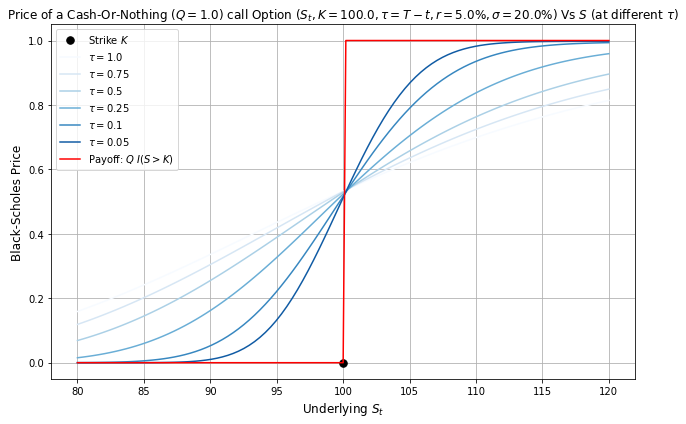

In [17]:
plot_multi_tau(CON_Call, S_strip, tau_strip)

and now a plain-vanilla put option

In [18]:
Vanilla_Put = PlainVanillaOption(option_type='put', S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2)
Vanilla_Put

PlainVanillaOption('put', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

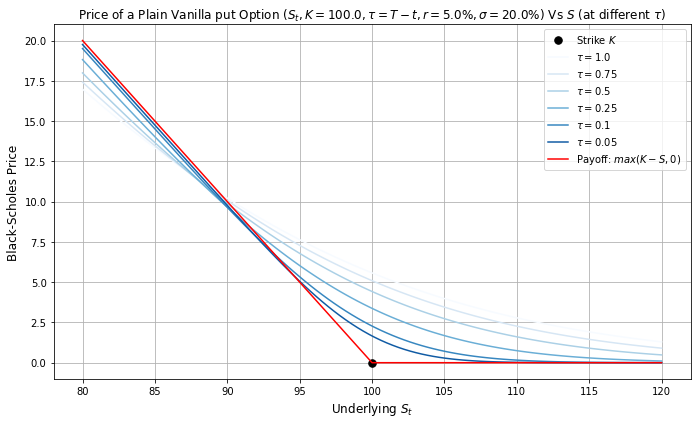

In [19]:
plot_multi_tau(Vanilla_Put, S_strip, tau_strip)

In [20]:
def plot_single_tau(option, S_list, tau):
    """
    plot_single_tau(option, S_list, tau) plot option prices for underlying in 'S_list' and time to maturity 'tau'.

    Parameters:
        option (PlainVanillaOption): instance of PlainVanillaOption class;
        S_list (List):               list of underlying values;
        tau (float):                 time to maturity (in years);
        
    Returns:
        None;

    """

    # define the figure
    fig, ax = plt.subplots(figsize=(10,6))
    
    # setting legend labels
    # plain vanilla case:
    if isinstance(option, PlainVanillaOption):
        title_label = "Plain Vanilla"
    # digital case:
    else:
        title_label = "Cash-Or-Nothing ($Q={}$)".format(option.get_Q())
            
    # auxiliary variable
    numS = len(S_list)

    # plot a dot to highlight the strike position
    ax.plot(option.get_K(), 0, 'k.', ms=15, label="Strike $K$")

    # plot the upper limit, the price and the lower limit for different underlying values
    upper_limit = np.zeros(numS)
    price       = np.zeros(numS)
    lower_limit = np.zeros(numS)
    payoff      = np.zeros(numS)

    for i in np.arange(numS):
        option.set_S(S_list[i]) # reset of underlying value
        
        upper_limit[i] = option.price_upper_limit()
        price[i]       = option.price()
        lower_limit[i] = option.price_lower_limit()
        payoff[i]      = option.payoff()

    ax.plot(S_list, upper_limit, 'k-.', lw=1.5, label=option.get_docstring('price_upper_limit'))
    ax.plot(S_list, price,       'b-',  lw=1.5, label=r"Price")
    ax.plot(S_list, lower_limit, 'k--', lw=1.5, label=option.get_docstring('price_lower_limit'))
    ax.plot(S_list, payoff,      'r-',  lw=1.5, label=option.get_docstring('payoff'))

    # set axis labels 
    ax.set_xlabel('Underlying $S_t$', fontsize=12) 
    ax.set_ylabel('Black-Scholes Price', fontsize=12) 

    # set title
    ax.set_title(r"Price of a {} {} Option $(S_t, K={}, \tau=T-t={:.1f}y, r={}\%, \sigma={}\%)$ Vs $S$ (with price limits)".
                 format(title_label, option.get_type(), option.get_K(), option.get_tau(), option.get_r()*100, 
                        option.get_sigma()*100), fontsize=12) 

    # add the legend ('best' loc parameters places the legend in the best position automatically)
    ax.legend(loc='best', ncol=1)

    # add a gride to ease visualization
    plt.grid(True)

    # show the plot
    fig.tight_layout()
    plt.show()

In [21]:
tau = 2.0

K_focus = 5

S_strip_focus = np.linspace(0, 10, 100)
S_strip_focus = np.append(S_strip_focus, K_focus)
S_strip_focus = np.sort(S_strip_focus)
S_strip_focus

array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.        ,  5.05050505,  5.15151515,  5.25252525,  5.35353535,
        5.45454545,  5.55555556,  5.65656566,  5.75757576,  5.85858586,
        5.95959596,  6.06060606,  6.16161616,  6.26262626,  6.36363636,
        6.46464646,  6.56565657,  6.66666667,  6.76767677,  6.86

In [22]:
CON_Call_focus = DigitalOption(option_type='call', 
                               cash_amount=1.0, 
                               S_t=3.0, 
                               K=5.0, 
                               t="19-04-2020", 
                               T="19-04-2022", 
                               r=0.05, 
                               sigma=0.2)

CON_Call_focus

DigitalOption('call', cash=1.0, S_t=3.0, K=5.0, t=19-04-2020, T=19-04-2022, tau=2.00y, r=5.0%, sigma=20.0%)

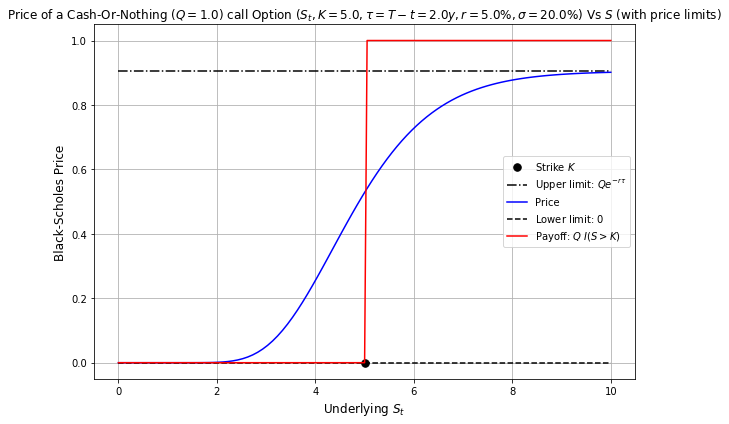

In [23]:
plot_single_tau(CON_Call_focus, S_strip_focus, CON_Call_focus.get_tau())

In [24]:
Vanilla_Put_focus = PlainVanillaOption(option_type='put', 
                                       S_t=3.0, 
                                       K=5.0, 
                                       t="19-04-2020", 
                                       T="19-04-2022", 
                                       r=0.05, 
                                       sigma=0.2)

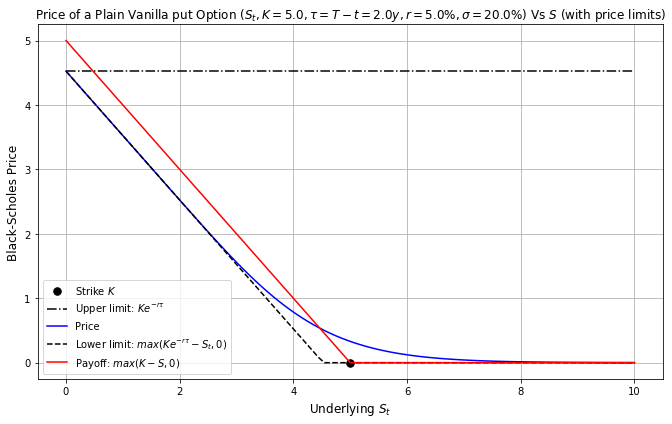

In [25]:
plot_single_tau(Vanilla_Put_focus, S_strip_focus, Vanilla_Put_focus.get_tau())

# 3. Inheritance <a name="inheritance"></a>

Given all the financial similarities between plain-vanilla and digital options, 

- don't you think that modeling `PlainVanillaOption` and `DigitalOption` as two completely unrelated classes is somehow at odds with their analogies? 

- And, looking at the body of the two classes, don't you think that there are a lot of repetitions?

_Inheritance_ is a way of arranging objects in a hierarchy from the most general one to the most specific one. It's a logical and programming paradygm modeling an _"is a"_ relationship between the most specific object and the most general one. At the end of the day, since both kind of options share european exercise (they cannot be exercised before expiration date $T$):

- a plain-vanilla option _is a_ european option,

- a digital option _is a_ european option.

We can translate this considerations defining a general `EuropeanOption` class and making `PlainVanillaOption` and `DigitalOption` _sub-classes_ of `EuropeanOption`. In this way, we are modeling the fact that:

- a `PlainVanillaOption` _is a_ `EuropeanOption`

- a `DigitalOption` _is a_ `EuropeanOption`.


We then refer to `EuropeanOption` class as the _parent_ (aka _mother_ or _base_ ) class and to any of `PlainVanillaOption` and `DigitalOption` as the _derived_ (aka _child_ or _sub-class_ ) class. 

The syntax is

```python
class BaseClass:
    ...
```
```python
class Child1(BaseClass):
    ...
```
```python
class Child2(BaseClass):
    ...
```
and you can have as many sub-classes as you want.

The idea is to put all the attributes and methods that the classes have in common in a base class. These will be inherited by sub-classes. Then define one or more subclasses with their own custom attributes and methods.

Here is our `EuropeanOption` base class implementation

In [1]:
class EuropeanOption:
    """
    EuropeanOption abstract class: an interface setting the template for any option with european-style exercise.
    This class is not meant to be instantiated.
    
    Attributes:
    -----------
        type (str):               type of the options. Can be either 'call' or 'put';
        S_t (float):              spot price of the underlying asset at the valuation date 't';
        K (float):                strike price;
        t (str; dt.datetime):     valuation date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        T (str; dt.datetime):     expiration date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        tau (float):              time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                continuously compounded short-rate;
        sigma (float):            volatility of underlying asset;
    
    Public Methods:
    --------   
    
        getters and setters for all common attributes
        
        payoff: float
            Template method for payoff. Raises NotImplementedError if called.

        price_upper_limit: float 
            Template method for upper limit. Raises NotImplementedError if called.

        price_lower_limit: float 
            Template method for lower limit. Raises NotImplementedError if called.
            
        price: float
            Template method for price. Raises NotImplementedError if called.

    """
    
    def __init__(self, option_type, S_t, K, t, T, r, sigma):
        
        print("Calling the EuropeanOption constructor!")

        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
        
        self.__type  = option_type
        self.__S     = S_t
        self.__K     = K
        self.__t     = dt.datetime.strptime(t, "%d-%m-%Y") if isinstance(t, str) else t
        self.__T     = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        self.__tau   = self.__time_to_maturity()
        self.__r     = r
        self.__sigma = sigma
        
        # empty informations dictionary
        self.__docstring_dict = {}        
        
    # string representation method template
    def __repr__(self):
        raise NotImplementedError()
    
    # getters
    def get_type(self):
        return self.__type
        
    def get_S(self):
        return self.__S
    
    def get_K(self):
        return self.__K
    
    def get_t(self):
        return self.__t

    def get_T(self):
        return self.__T

    def get_tau(self):
        return self.__tau
    
    def get_r(self):
        return self.__r

    def get_sigma(self):
        return self.__sigma
    
    # doctring getter template
    def get_docstring(self, label):
        raise NotImplementedError()

    # setters
    def set_type(self, option_type):
        self.__type = option_type
        
        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
            
    def set_S(self, S):
        self.__S = S
        
    def set_K(self, K):
        self.__K = K
    
    def set_t(self, t):
        self.__t = dt.datetime.strptime(t, "%d-%m-%Y") if isinstance(t, str) else t
        # update time to maturity, given changed t, to keep internal consistency
        self.__update_tau() 

    def set_T(self, T):
        self.__T = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        # update time to maturity, given changed T, to keep internal consistency
        self.__update_tau() 
    
    def set_tau(self, tau):
        self.__tau = tau
        # update expiration date, given changed tau, to keep internal consistency
        # we could have updated valuation date as well, but this is a stylistic choice
        self.__update_T()

    def set_r(self, r):
        self.__r = r

    def set_sigma(self, sigma):
        self.__sigma = sigma
        
    # update methods (private)
    def __update_tau(self):
        self.__tau = self.__time_to_maturity()

    def __update_T(self):
        self.__T = self.__t + dt.timedelta(days=math.ceil(self.__tau*365))

    # time to maturity method (private)
    def __time_to_maturity(self):
        return (self.__T - self.__t).days / 365.0
    
    # payoff template
    def payoff(self):
        raise NotImplementedError()     
        
    # upper price limit template
    def price_upper_limit(self):
        raise NotImplementedError()     

    # lower price limit template
    def price_lower_limit(self):
        raise NotImplementedError()     
        
    # price template
    def price(self):
        raise NotImplementedError()     

Notice that `EuropeanOption` defines all common attributes and methods. This avoid a lot of code repetition. Look for example at the time-to-maturity computation

```python
def __time_to_maturity(self):
    return (self.__T - self.__t).days / 365.0
```

since all european options derived from `EuropeanOption` should feature a time-to-maturity, it definitely makes sense to implement it here once-for-all and make it _inherited_ by all the sub-classes of `EuropeanOption`.

On the other side, since the cash amount $Q$ paid at maturity is a parameter of CON options, but not plain-vanilla ones, it makes sense to implement it as an attribute `self.__Q` in `DigitalOption` class only.

Here are the derived classes: look how much code we are saving w.r.t. their previous implementation as independent classes. Also, look how armhonically they integrate: we are leveraging on the financial similarities between the two kind of contracts, translating them in a considerable sharing of properties.

In [27]:
class PlainVanillaOption(EuropeanOption):
    """
    PlainVanillaOption class implementing payoff and pricing of plain-vanilla call and put options.
    Put price is calculated using put-call parity
    
    Attributes:
    -----------
        type (str):               type of the options. Can be either 'call' or 'put';
        S_t (float):              spot price of the underlying asset at the valuation date 't';
        K (float):                strike price;
        t (str; dt.datetime):     valuation date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        T (str; dt.datetime):     expiration date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        tau (float):              time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                continuously compounded short-rate;
        sigma (float):            volatility of underlying asset;
    
    Methods:
    --------   
    
        payoff: float
            Computes the payoff of the option and returns it

        price_upper_limit: float 
            Returns the upper limit for a vanilla option price.

        price_lower_limit: float 
            Returns the lower limit for a vanilla option price.
            
        price: float
            Computes the exact price of the option and returns it, using call_price() or put_price()

    """
    
    # initializer with default arguments
    def __init__(self, option_type='call', S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2):    
        # calling the EuropeanOption constructor
        super(PlainVanillaOption, self).__init__(option_type, S_t, K, t, T, r, sigma)
        
        # additional stuff - PlainVanillaOption-specific

        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $S_t$",
                'payoff':            r"Payoff: $max(S-K, 0)$",
                'price_lower_limit': r"Lower limit: $max(S_t - K e^{-r \tau}, 0)$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $K e^{-r \tau}$",
                'payoff':            r"Payoff: $max(K-S, 0)$",
                'price_lower_limit': r"Lower limit: $max(K e^{-r \tau} - S_t, 0)$"}
        }
                
    def __repr__(self):
        return r"PlainVanillaOption('{}', S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # docstring getter
    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label] 
    
    # payoff calculation
    def payoff(self):
        # call case
        if self.get_type() == 'call':
            return max(0.0, self.get_S() - self.get_K())
        # put case
        else:
            return max(0.0, self.get_K() - self.get_S())

    # upper price limit
    def price_upper_limit(self):
        # call case
        if self.get_type() == 'call':
            return self.get_S()
        # put case
        else:
            return self.get_K()*np.exp(-self.get_r() * self.get_tau())

    # lower price limit
    def price_lower_limit(self):
        # call case
        if self.get_type() == 'call':
            return max(self.get_S() - self.get_K()*np.exp(-self.get_r() * self.get_tau()), 0)
        # put case
        else:
            return max(self.get_K()*np.exp(-self.get_r() * self.get_tau()) - self.get_S(), 0)
            
    # price calculation
    def price(self):
        # call case
        if self.get_type() == 'call':
            return self.__call_price()
        # put case
        else:
            return self.__put_price()
          
    def __call_price(self):
        
        # some local variables retrieved to be used repeatedly
        S = self.get_S()
        tau = self.get_tau()
        
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.payoff()
        else:
            K     = self.get_K()
            r     = self.get_r()
            sigma = self.get_sigma()

            d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
            d2 = d1 - sigma * np.sqrt(tau)

            price = S * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self):
        """ Put price from Put-Call parity relation: Call + Ke^{-r*tau} = Put + S"""
        return self.__call_price() + self.get_K() * np.exp(- self.get_r() * self.get_tau()) - self.get_S()        

In [28]:
class DigitalOption(EuropeanOption):
    """
    DigitalOption class implementing payoff and pricing of digital call and put options.
    Put price is calculated using put-call parity
    
    Attributes:
    -----------
        type (str):               type of the options. Can be either 'call' or 'put';
        Q (float):                cash amount
        S_t (float):              spot price of the underlying asset at the valuation date 't';
        K (float):                strike price;
        t (str; dt.datetime):     valuation date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        T (str; dt.datetime):     expiration date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        tau (float):              time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                continuously compounded short-rate;
        sigma (float):            volatility of underlying asset;
    
    Public Methods:
    --------   
    
        getter and setter for cash amount attribute
        
        payoff: float
            Computes the payoff of the option and returns it

        price_upper_limit: float 
            Returns the upper limit for a CON digital option price.

        price_lower_limit: float 
            Returns the lower limit for a CON digital option price
            .
        price: float
            Computes the exact price of the option and returns it, using call_price() or put_price()

    """
    
    # initializer with default arguments    
    def __init__(self, option_type='call', cash_amount = 1.0, S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2):
        # calling the EuropeanOption constructor
        super(DigitalOption, self).__init__(option_type, S_t, K, t, T, r, sigma)        

        # additional stuff - DigitalOption-specific
        self.__Q = cash_amount
        
        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S > K)$",
                'price_lower_limit': r"Lower limit: $0$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S \leq K)$",
                'price_lower_limit': r"Lower limit: $0$"}
        }        
                
    def __repr__(self):
        return r"DigitalOption('{}', cash={:.1f}, S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_Q(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_Q(self):
        return self.__Q
    
    # docstring getter
    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label] 
    
    # setters
    def set_Q(self, cash_amount):
        self.__Q = cash_amount
    
    # payoff calculation
    def payoff(self):
        # call case
        if self.get_type() == 'call':
            return self.get_Q() * int(self.get_S() > self.get_K())
        # put case
        else:
            return self.get_Q() * int(self.get_S() <= self.get_K())
        
    # upper price limit
    def price_upper_limit(self):
        # call case
        if self.get_type() == 'call':
            return self.get_Q()*np.exp(-self.get_r() * self.get_tau())
        # put case
        else:
            return self.get_Q()*np.exp(-self.get_r() * self.get_tau())

    # lower price limit
    def price_lower_limit(self):
        # call case
        if self.get_type() == 'call':
            return 0.0
        # put case
        else:
            return 0.0
        
    # price calculation
    def price(self):
        # call case
        if self.get_type() == 'call':
            return self.__call_price()
        # put case
        else:
            return self.__put_price()
          
    def __call_price(self):
        
        # some local variables retrieved to be used repeatedly
        S = self.get_S()
        tau = self.get_tau()
        
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.payoff()
        else:
            Q     = self.get_Q()
            K     = self.get_K()
            r     = self.get_r()
            sigma = self.get_sigma()

            d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
            d2 = d1 - sigma * np.sqrt(tau)

            price = Q * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self):
        """ Put price from Put-Call parity relation: CON_Call + CON_Put = Qe^{-r*tau}"""
        return self.get_Q() * np.exp(- self.get_r() * self.get_tau()) - self.__call_price()        

Notice that the `__init__` method of the `EuropeanOption` base class initialises all the instance variables that are common to both `PlainVanillaOption` and `DigitalOption`. In each sub-class we define another `__init__` method (it's then an _overriden_ method, see below) so that we can use it to initialize that class's attributes and from its body we call the `EuropeanOption` `__init__` method to initialize common attributes. The base class initializer can be called from a derived class using the `super()` function like

```python
super(DerivedClass, self).__init__(parameters_of_the_BaseClass_initializer)    
```

Let's see this instantiating a plain-vanilla option

In [29]:
Vanilla_Call = PlainVanillaOption(option_type='call', S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2)
Vanilla_Call

Calling the EuropeanOption constructor!


PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

Do you see the message print on screen? It comes from the `__init__` method of `EuropeanOption`

_En passant,_ notice that we can initialize `PlainVanillaOption` (and `DigitalOption` as well) using default parameters.

In [30]:
Vanilla_Call = PlainVanillaOption()
Vanilla_Call

Calling the EuropeanOption constructor!


PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [31]:
type(Vanilla_Call)

__main__.PlainVanillaOption

In [32]:
isinstance(Vanilla_Call, PlainVanillaOption)

True

In [33]:
Vanilla_Call.get_K()

100.0

In [34]:
Vanilla_Call.price()

3.487402470943657

Similarly, let's instantiate a digital CON option

In [35]:
CON_Call = DigitalOption()
CON_Call

Calling the EuropeanOption constructor!


DigitalOption('call', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [36]:
type(CON_Call)

__main__.DigitalOption

In [37]:
isinstance(CON_Call, DigitalOption)

True

In [38]:
CON_Call.get_K()

100.0

In [39]:
CON_Call.get_Q()

1.0

In [40]:
CON_Call.price()

0.29674605684957245

## 3.1. Abstract classes and interfaces <a name="abstract"></a>

Let's go back `EuropeanOption` class. Notice that most of its methods are left empty (eventually raising a `NotImplementedError()` to prevent from being called). Let's see this in practice, instantiating a generic european option and considering for example the `.price()` method

```python
    # price template
    def price(self):
        raise NotImplementedError()     
```

In [41]:
European_Call_generic = EuropeanOption(option_type='call', S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2)
European_Call_generic

Calling the EuropeanOption constructor!


In [42]:
# raises NotImplementedError:
#
# European_Call_generic.price()

This modeling choice has been taken because our `EuropeanOption` class is not meant to be instantiated. It is meant only to serves as a _template_ (or _interface_ ) according to which all options with european-style exercise (that we derive from her) should conform. 

Here we are making all classes derived from `EuropeanOption` _inheriting_ this method and we are imposing that each of them should _override_ (see next section) it providing a specific implementation for the method according to their needs.

We say that `EuropeanOption` is an _abstract_ class. We instantiate options through its sub-classes only.

## 3.2. Inheritance and Polymorphism <a name="inheritance-and-poly"></a>

Given a `.method()` implemented in the base class, sub-classes are also free to re-implement the same method (that is, keeping its name). Methods defined in the base class and re-implemented by the derived classes are known as _overriden_ methods. Therefore sub-classes implement polymorphism through the methods they override from the base class. 

An example we have already encountered is the `.price()` method, that is defined in `EuropeanOption` class as an empty method (raising a `NotImplementedError()` error message if called) and that both `PlainVaillaOption` and `DigitalOption` classes re-implement according to their specific needs.

We can se this in practice again using our plotting functions

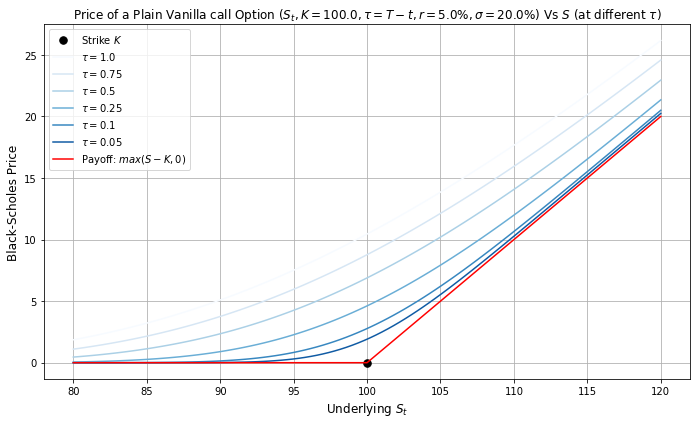

In [43]:
plot_multi_tau(Vanilla_Call, S_strip, tau_strip)

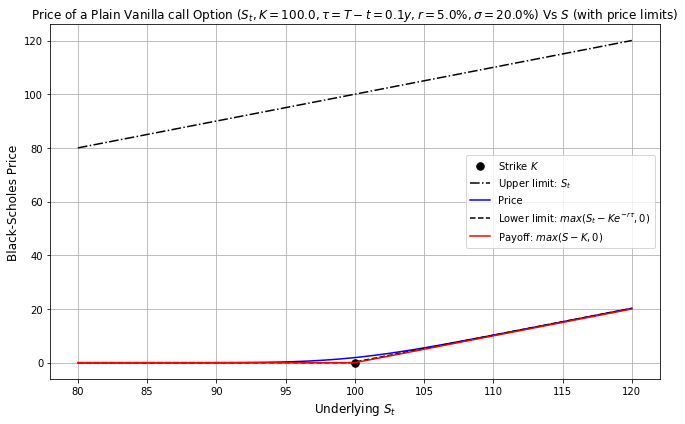

In [44]:
plot_single_tau(Vanilla_Call, S_strip, Vanilla_Call.get_tau())

Now a plain-vanilla put option

In [45]:
Vanilla_Put = PlainVanillaOption(option_type='put', S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2)
Vanilla_Put

Calling the EuropeanOption constructor!


PlainVanillaOption('put', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

which is equivalent to

In [46]:
Vanilla_Put = PlainVanillaOption(option_type='put')
Vanilla_Put

Calling the EuropeanOption constructor!


PlainVanillaOption('put', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [47]:
type(Vanilla_Put)

__main__.PlainVanillaOption

In [48]:
isinstance(Vanilla_Put, PlainVanillaOption)

True

In [49]:
Vanilla_Put.get_K()

100.0

In [50]:
Vanilla_Put.price()

10.041330587465126

In [51]:
Vanilla_Put.payoff()

10.0

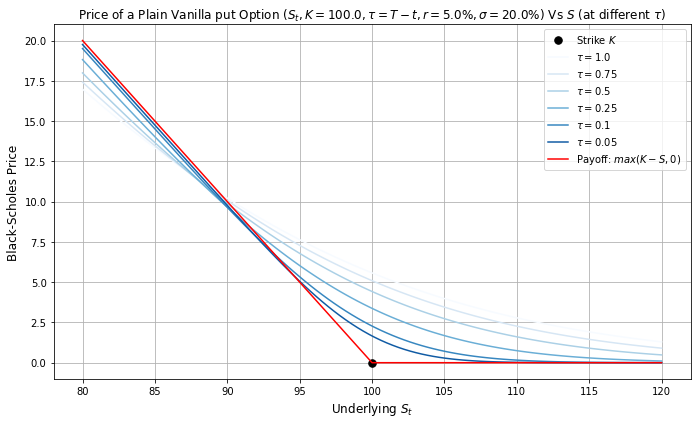

In [52]:
plot_multi_tau(Vanilla_Put, S_strip, tau_strip)

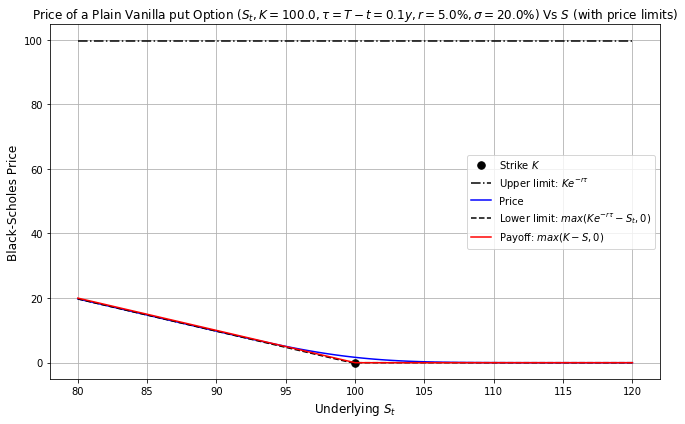

In [53]:
plot_single_tau(Vanilla_Put, S_strip, Vanilla_Put.get_tau())

Now a plain-vanilla digital CON option

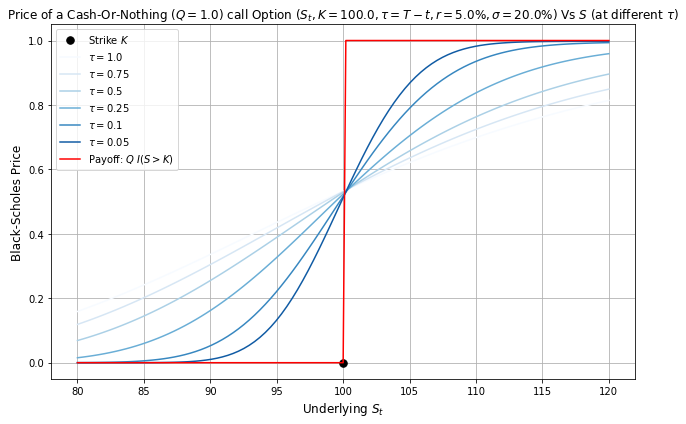

In [54]:
plot_multi_tau(CON_Call, S_strip, tau_strip)

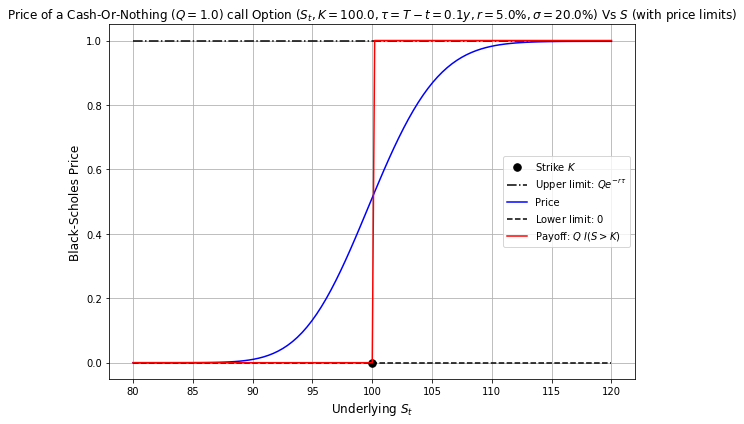

In [55]:
plot_single_tau(CON_Call, S_strip, CON_Call.get_tau())

and digital CON put option 

In [56]:
CON_Put = DigitalOption(option_type='put', cash_amount = 1.0, S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2)
CON_Put

Calling the EuropeanOption constructor!


DigitalOption('put', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

equivalent to

In [57]:
CON_Put = DigitalOption(option_type='put')
CON_Put

Calling the EuropeanOption constructor!


DigitalOption('put', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [58]:
type(CON_Put)

__main__.DigitalOption

In [59]:
isinstance(CON_Put, DigitalOption)

True

In [60]:
CON_Put.get_K()

100.0

In [61]:
CON_Put.get_Q()

1.0

In [62]:
CON_Put.price()

0.6687932243156424

In [63]:
CON_Put.payoff()

1.0

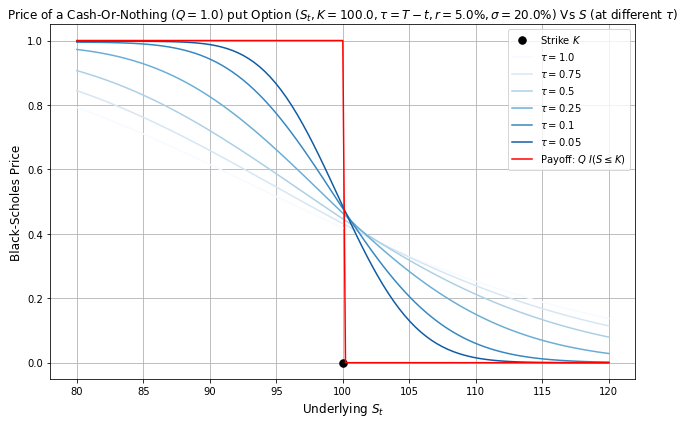

In [64]:
plot_multi_tau(CON_Put, S_strip, tau_strip)

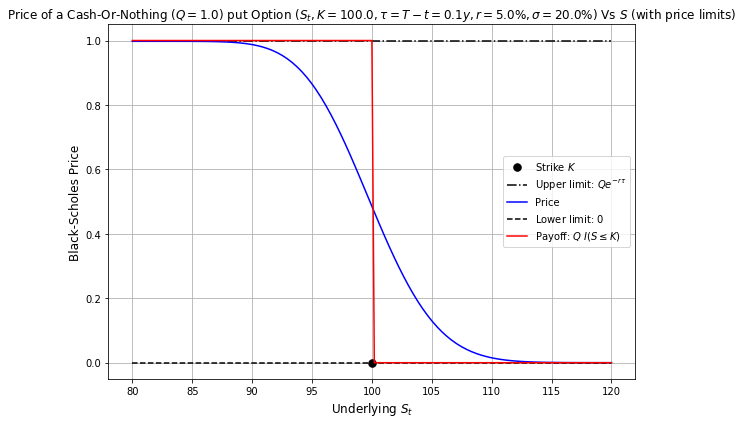

In [65]:
plot_single_tau(CON_Put, S_strip, CON_Put.get_tau())

**TAKE-HOME MESSAGE**: key points are that

- all sub-classes derive attributes and methods defined in the base class. So that you define common attributes and methods once-for-all in the base class, and then you are able to access and use them from any of the sub-classes. 

- attributes and/or methods which are specific to one sub-class only are defined within that sub-class only.